In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [2]:
with open(pickle_dir / 'population_patterns_checks.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [3]:
def plot_overlaps(all_overlaps, title):
    plt.figure()
    plt.hist(all_overlaps, bins=20, alpha=0.4, weights=np.ones(len(all_overlaps)) / len(all_overlaps))
    plt.title(title, fontsize=14)
    plt.ylabel("Proportion of Hops", fontsize=12)
    plt.xlabel("Population Overlap", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((0, 0.6))
    plt.show()
    print(len(all_overlaps))

# Cache/Retrievals

### Activity Overlap Between Caching and Retrieval of Same Cache

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                max_val = np.nanmax(cache_retriev_overlap)
                if not np.isnan(max_val):
                    overlaps.append(np.nanmax(cache_retriev_overlap))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
            break
        
plot_overlaps(all_overlaps, "Cache vs Retrieval at Same Site")

#### View patterns and define new episode cells by cells that support overlap

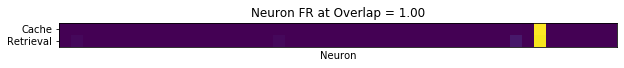

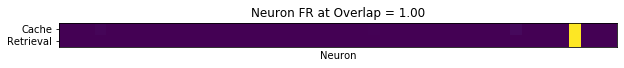

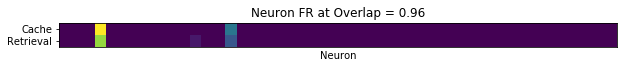

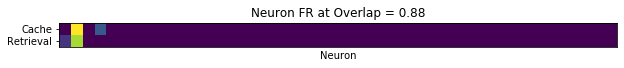

triggered


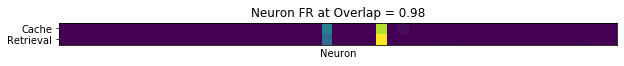

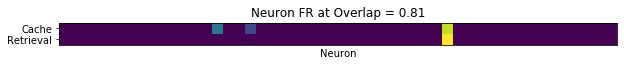

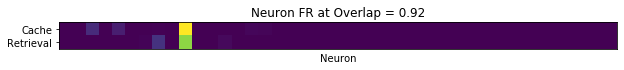

triggered


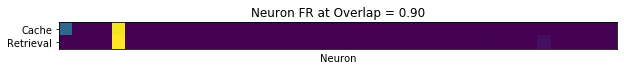

triggered


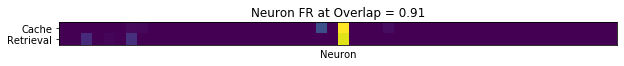

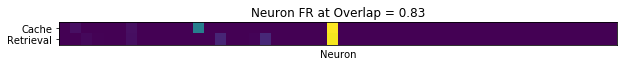

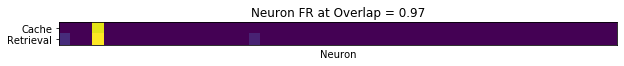

triggered


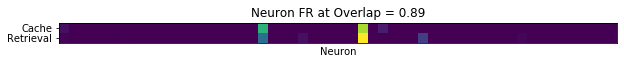

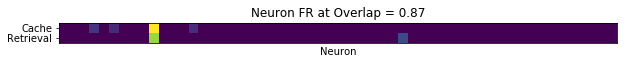

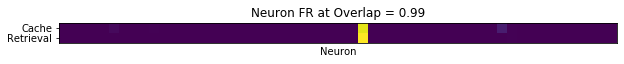

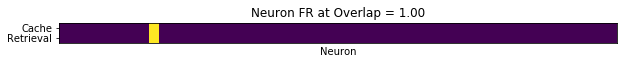

triggered
triggered


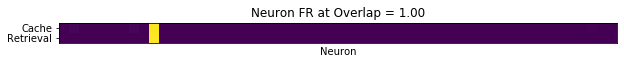

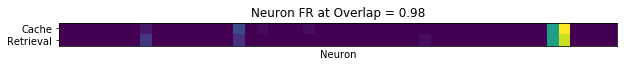

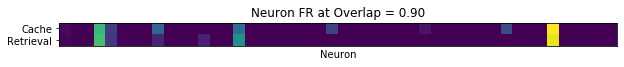

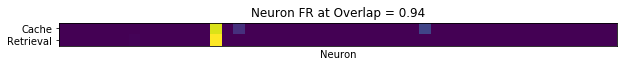

triggered
triggered


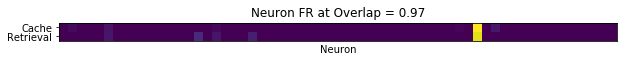

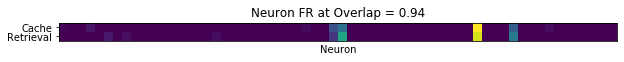

triggered


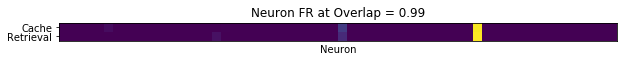

triggered


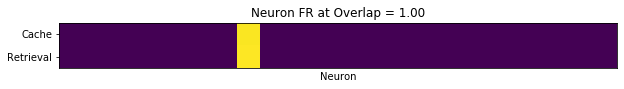

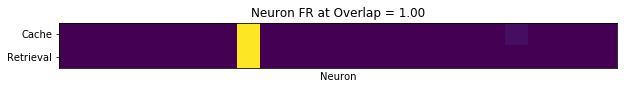

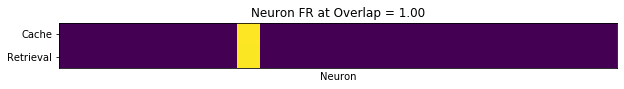

triggered


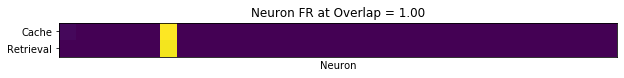

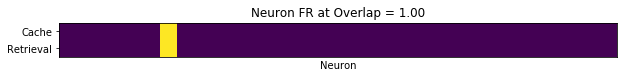

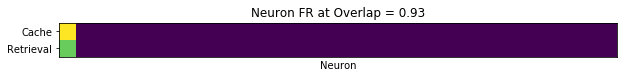

triggered
triggered


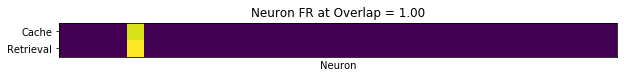

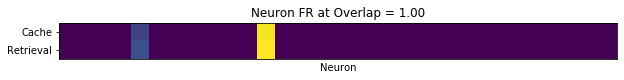

triggered
triggered
triggered
triggered
triggered
triggered
triggered
triggered


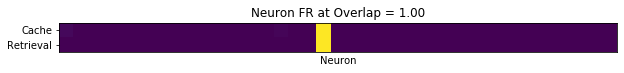

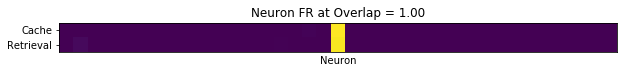

triggered
triggered
triggered
triggered
triggered
triggered


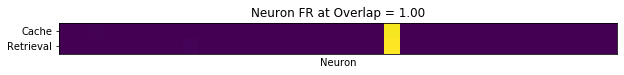

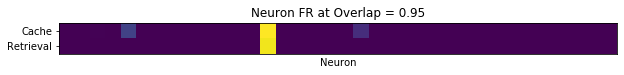

triggered


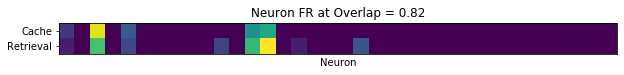

triggered


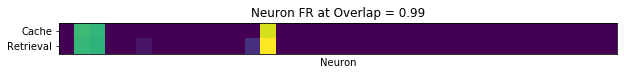

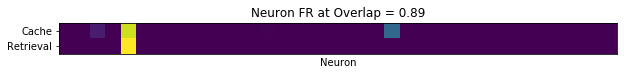

triggered


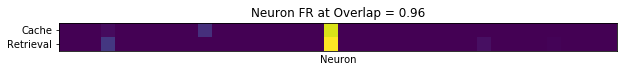

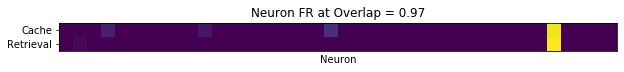

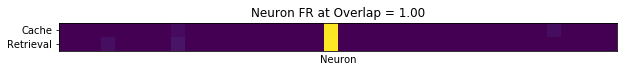

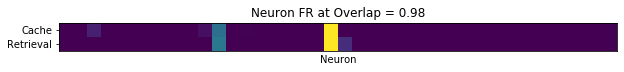

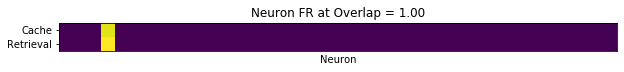

triggered


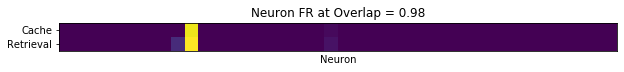

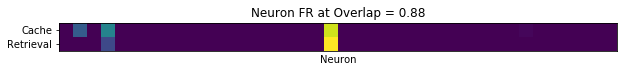

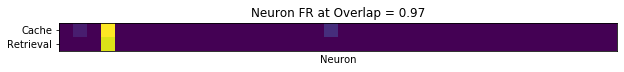

triggered


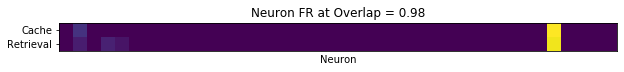

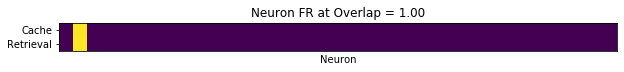

triggered
triggered


/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered


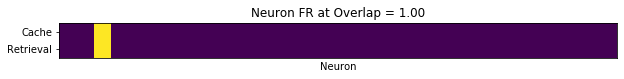

triggered
triggered


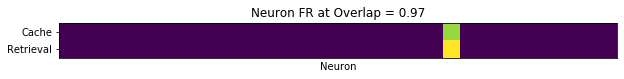

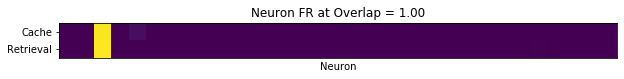

triggered


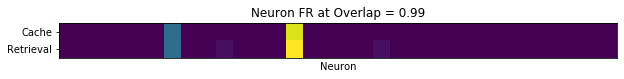

triggered


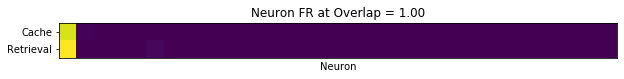

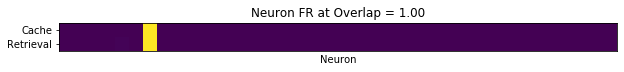

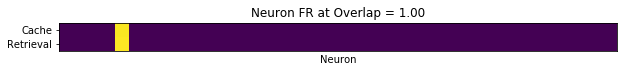

triggered
triggered
triggered
triggered
triggered


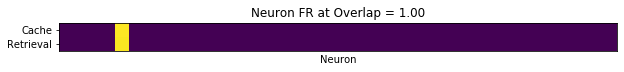

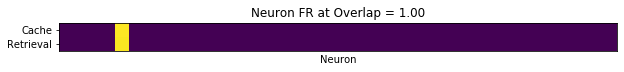

triggered
triggered
triggered


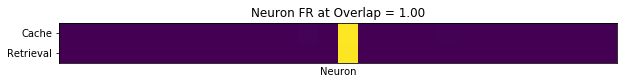

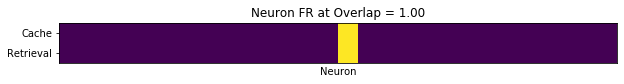

triggered


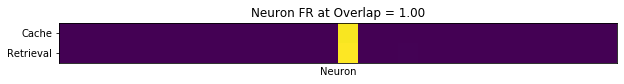

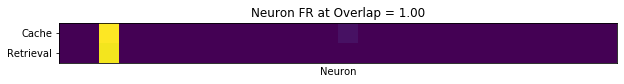

triggered
triggered
triggered
triggered
triggered


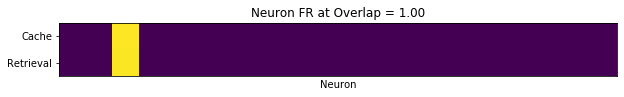

triggered


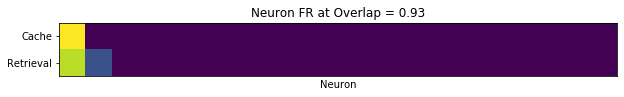

triggered
triggered
triggered


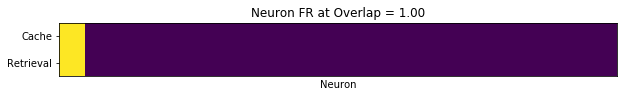

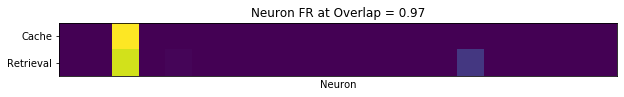

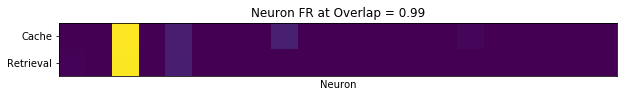

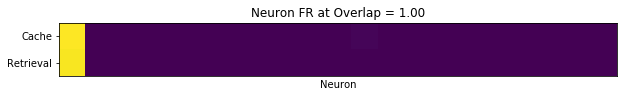

triggered


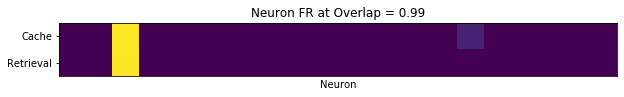

triggered


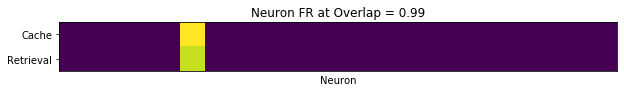

triggered
triggered
triggered


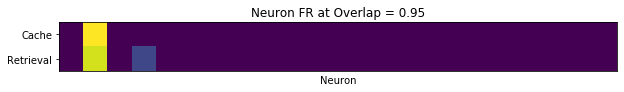

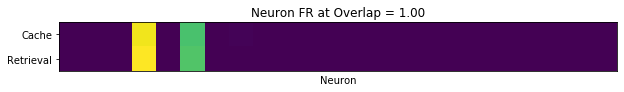

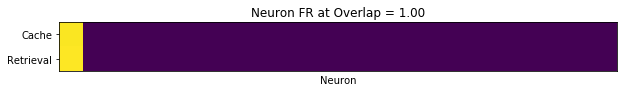

triggered
triggered
triggered


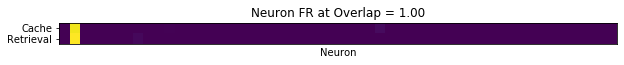

triggered


In [5]:
data = {}
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    data[fil_string] = {}
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_windows = population_patterns[fil_string]['hop_times']
    cache_idx_mat = np.zeros((c_hops.size, exp_data.num_neurs))
    cache_idx_mat_avg_repr = np.zeros((c_hops.size, exp_data.num_neurs))
    significance = np.zeros(exp_data.num_neurs)

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            overlaps = []
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            max_patterns = []
            max_idxs = []
            for r_idx, retriev_pattern in enumerate(retriev_pattern_mat.T):
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                val = np.nanmax(cache_retriev_overlap)
                if not np.isnan(val):
                    overlaps.append(val)
                    max_patterns.append([
                        cache_pattern_mat[:,np.argmax(cache_retriev_overlap)], retriev_pattern
                        ])
                    max_idxs.append([
                        hop_windows[c_hop][np.argmax(cache_retriev_overlap).item()],
                        hop_windows[r_hop][r_idx]
                        ])
            if len(overlaps) > 0:
                max_idx = max_idxs[np.argmax(overlaps)]
                if exp_data.wedges[max_idx[0]] != c_site or exp_data.wedges[max_idx[0]] != c_site:
                    print("triggered")
                    continue
                max_patterns = np.array(max_patterns[np.argmax(overlaps)])
                support_neurs = np.argwhere(max_patterns[0]*max_patterns[1] > 0).squeeze()
                true_pattern = np.zeros(exp_data.num_neurs)
                true_pattern[support_neurs] = np.mean(max_patterns[:, support_neurs], axis=0)
                cache_idx_mat[i, :] = true_pattern
                mean_pattern = np.mean(max_patterns, axis=0)
                cache_idx_mat_avg_repr[i, :] = mean_pattern
                significance[support_neurs] = 1
                max_overlap = np.nanmax(overlaps)
                if max_overlap > 0.8:
                    plt.figure(figsize=(10,10))
                    plt.imshow(max_patterns)
                    plt.xticks([])
                    plt.xlabel("Neuron")
                    plt.yticks([0,1], ['Cache', 'Retrieval'])
                    plt.title(f"Neuron FR at Overlap = {max_overlap:.2f}")
                    plt.show()
            break
    data[fil_string]['cr_idx_mat'] = cache_idx_mat
    data[fil_string]['cr_idx_mat_avg_repr'] = cache_idx_mat_avg_repr
    data[fil_string]['significance'] = significance
with open(pickle_dir / 'episode_cells_overlap.p', 'wb') as f: 
    pickle.dump(data, f)

#### Activity Overlap between Cache/Retrieval with highest pair removed

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            overlaps = []
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            for retriev_pattern in retriev_pattern_mat.T:
                for c in cache_pattern_mat.T:
                    x = c.copy()
                    y = retriev_pattern.copy()
                    high_pair = np.argmax(x*y).squeeze()
                    x[high_pair] = 0
                    y[high_pair] = 0
                    cache_retriev_overlap = popln_overlap(
                        x[:,None], y
                        )
                    if np.isnan(cache_retriev_overlap): continue
                    overlaps.append(cache_retriev_overlap)
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
            break
        
plot_overlaps(all_overlaps, "Cache vs Retrieval")

### Activity Overlap Between Caching and Retrieval of Different Cache

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered


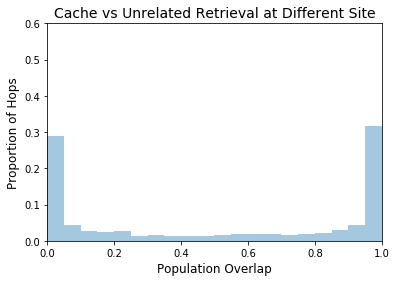

1684


In [14]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        mean_overlaps = []
        for j, r_hop in enumerate(r_hops):
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site == c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                max_val = np.nanmax(popln_overlap(cache_pattern_mat, retriev_pattern))
                if not np.isnan(max_val):
                    overlaps.append(max_val)
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Unrelated Retrieval at Different Site")

# Checks

### Activity Overlap Between Caching and Checks of Occupied Cache

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered


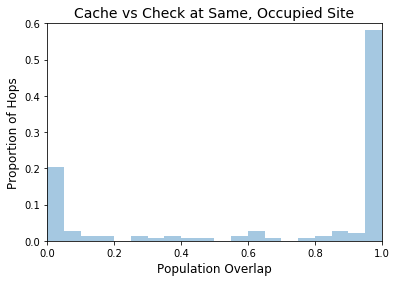

148


In [4]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    ch_hops = population_patterns[fil_string]['ch_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    if ch_hops.size == 0: continue

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, ch_hop in enumerate(ch_hops):
            ch_site = exp_data.event_sites[exp_data.check_event][j]
            if ch_site != c_site: continue
            if not exp_data.cache_present[ch_hop, c_site-1]: continue
            check_pattern_mat = hop_patterns[ch_hop]
            overlaps = []
            for check_pattern in check_pattern_mat.T:
                cache_check_overlap = popln_overlap(
                    cache_pattern_mat, check_pattern
                    )
                max_val = np.nanmax(cache_check_overlap)
                if not np.isnan(max_val):
                    overlaps.append(np.nanmax(cache_check_overlap))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))             
        
plot_overlaps(all_overlaps, "Cache vs Check at Same, Occupied Site")

### Activity Overlap Between Caching and Checks of Unoccupied Cache

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered


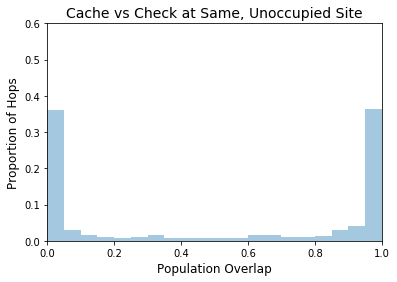

1044


In [5]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    ch_hops = population_patterns[fil_string]['ch_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    if ch_hops.size == 0: continue

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        assert(ch_hops.size == np.sum(exp_data.check_event))
        for j, ch_hop in enumerate(ch_hops):
            ch_site = exp_data.event_sites[exp_data.check_event][j]
            if ch_site != c_site: continue
            if exp_data.cache_present[ch_hop, c_site-1]: continue
            check_pattern_mat = hop_patterns[ch_hop]
            overlaps = []
            for check_pattern in check_pattern_mat.T:
                cache_check_overlap = popln_overlap(
                    cache_pattern_mat, check_pattern
                    )
                max_val = np.nanmax(cache_check_overlap)
                if not np.isnan(max_val):
                    overlaps.append(np.nanmax(cache_check_overlap))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Check at Same, Unoccupied Site")

### Activity Overlap Between Occupied vs Unoccupied Check

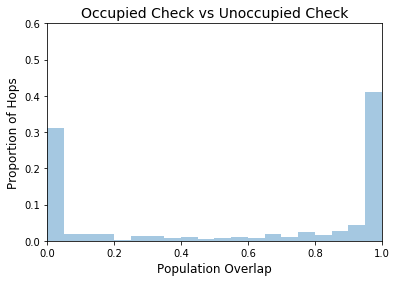

605


In [6]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    ch_hops = population_patterns[fil_string]['ch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    if ch_hops.size == 0: continue

    for i, ch_hop in enumerate(ch_hops):
        ch_site = exp_data.event_sites[exp_data.check_event][i]
        if not exp_data.cache_present[ch_hop, ch_site-1]: continue
        check_pattern_mat = hop_patterns[ch_hop]
        for j, ch2_hop in enumerate(ch_hops):
            if j <= i: continue
            ch2_site = exp_data.event_sites[exp_data.check_event][j]
            if ch_site != ch2_site: continue
            if exp_data.cache_present[ch2_hop, ch2_site-1]: continue
            check2_pattern_mat = hop_patterns[ch2_hop]
            overlaps = []
            for check2_pattern in check2_pattern_mat.T:
                check_check2_overlap = popln_overlap(
                    check_pattern_mat, check2_pattern
                    )
                max_val = np.nanmax(check_check2_overlap)
                if not np.isnan(max_val):
                    overlaps.append(np.nanmax(check_check2_overlap))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Occupied Check vs Unoccupied Check")

### Activity Overlap Between Occupied Checks and Arbitrary Hop

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered


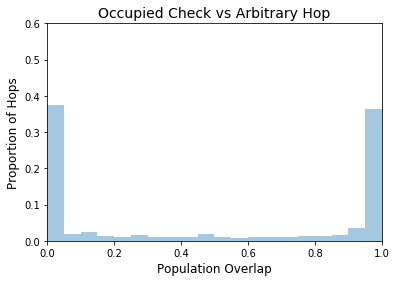

3358


In [7]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    ch_hops = population_patterns[fil_string]['ch_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, ch_hop in enumerate(ch_hops):
        ch_site = exp_data.event_sites[exp_data.check_event][i]
        if not exp_data.cache_present[ch_hop, ch_site-1]: continue
        check_pattern_mat = hop_patterns[ch_hop]
        for j, noncrch_hop in enumerate(noncrch_hops):
            overlaps = []
            noncrch_site = exp_data.hop_end_wedges[noncrch_hop]
            if noncrch_site != ch_site: continue
            navig_pattern_mat = hop_patterns[noncrch_hop]
            for navig_pattern in navig_pattern_mat.T:
                check_nav_overlap = popln_overlap(
                    check_pattern_mat, navig_pattern
                    )
                max_val = np.nanmax(check_nav_overlap)
                if not np.isnan(max_val):
                    overlaps.append(max_val)
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Occupied Check vs Arbitrary Hop")

### Activity Overlap Between Unoccupied Checks and Arbitrary Hop

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN axis encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


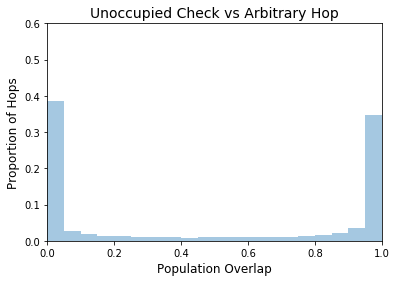

49343


In [8]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    ch_hops = population_patterns[fil_string]['ch_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, ch_hop in enumerate(ch_hops):
        ch_site = exp_data.event_sites[exp_data.check_event][i]
        if exp_data.cache_present[ch_hop, ch_site-1]: continue
        check_pattern_mat = hop_patterns[ch_hop]
        for j, noncrch_hop in enumerate(noncrch_hops):
            overlaps = []
            noncrch_site = exp_data.hop_end_wedges[noncrch_hop]
            if noncrch_site != ch_site: continue
            navig_pattern_mat = hop_patterns[noncrch_hop]
            for navig_pattern in navig_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(check_pattern_mat, navig_pattern)
                    ))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Unoccupied Check vs Arbitrary Hop")